In [44]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
from sklearn.model_selection import train_test_split

plt.style.use("ggplot")
pyro.set_rng_seed(3317)
np.random.seed(3317)


In [45]:
def g(x):
    return -(torch.sin(6 * torch.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


In [46]:
def generate_data(l=30, split=1.0 / 3.0):
    """
    Generate training and test data for the function g(x) = -(sin(6*pi*x)^2) + 6x^2 - 5x^4 + 3/2.
    :param l: Number of data points.
    :param split: Fraction of data to use as test data.
    :return: x_train, y_train, x_test, y_test
    """
    x = (torch.arange(1, l + 1) - 1) / (l - 1)
    y = g(x) + torch.sqrt(torch.tensor(0.01)) * torch.randn(len(x))

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=split, random_state=3317
    )

    return x_train, y_train, x_test, y_test


In [47]:
def log_likelihood(x, y, posterior_samples):
    rbf_l = torch.mean(posterior_samples["kernel.kern0.lengthscale"])
    rbf_v = torch.mean(posterior_samples["kernel.kern0.variance"])
    per_l = torch.mean(posterior_samples["kernel.kern1.lengthscale"])
    per_p = torch.mean(posterior_samples["kernel.kern1.period"])
    per_v = torch.mean(posterior_samples["kernel.kern1.variance"])
    noise = torch.mean(posterior_samples["noise"])

    rbf = gp.kernels.RBF(input_dim=1, variance=rbf_v, lengthscale=rbf_l)

    periodic = gp.kernels.Periodic(
        input_dim=1, period=per_p, lengthscale=per_l, variance=per_v
    )

    kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)

    noise_y = noise

    n_samples = len(x)
    K = kernel.forward(x)

    # ToDo mention that we are using the Cholesky decomposition
    # for the numerical stability of the computation
    # and for performance reasons
    # also add reference to the book

    # Compute the Cholesky decomposition
    upper = False
    L = torch.linalg.cholesky(K + noise_y * torch.eye(n_samples), upper=upper)

    alpha = torch.cholesky_solve(y.reshape(-1, 1), L, upper=upper)
    alpha = alpha.squeeze()
    # L being a diagonal matrix has the determinant equal to the sum of the log of
    # the element on the diagonal
    log_det = torch.sum(torch.log(torch.diag(L)))

    # Negative log-likelihood
    NLL = -0.5 * (
        torch.dot(y.T, alpha)
        + log_det
        + n_samples * torch.log(torch.tensor(2.0) * torch.pi)
    )

    return NLL


In [48]:
# def approximate_log_likelihood(x, y, posterior_samples):
#     log_likelihoods = []
#     for rbf_l, rbf_v, per_l, per_p, per_v, noise in zip(
#         posterior_samples["kernel.kern0.lengthscale"],
#         posterior_samples["kernel.kern0.variance"],
#         posterior_samples["kernel.kern1.lengthscale"],
#         posterior_samples["kernel.kern1.period"],
#         posterior_samples["kernel.kern1.variance"],
#         posterior_samples["noise"],
#     ):
#         log_likelihoods.append(
#             log_likelihood(x, y, [rbf_l, rbf_v, per_l, per_p, per_v, noise])
#         )
#     return torch.tensor(log_likelihoods).mean()


In [49]:
# def approximate_log_likelihood_2(x, y, posterior_samples):
#     rbf_l = torch.mean(posterior_samples["kernel.kern0.lengthscale"])
#     rbf_v = torch.mean(posterior_samples["kernel.kern0.variance"])
#     per_l = torch.mean(posterior_samples["kernel.kern1.lengthscale"])
#     per_p = torch.mean(posterior_samples["kernel.kern1.period"])
#     per_v = torch.mean(posterior_samples["kernel.kern1.variance"])
#     noise = torch.mean(posterior_samples["noise"])

#     nll = log_likelihood(x, y, [rbf_l, rbf_v, per_l, per_p, per_v, noise])

#     return torch.tensor(nll)

In [50]:
x_train, y_train, x_test, y_test = generate_data()

# Defining our kernels and GP-model
rbf = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
)
periodic = gp.kernels.Periodic(
    input_dim=1,
    period=torch.tensor(0.5),
    lengthscale=torch.tensor(1.0),
    variance=torch.tensor(1.0),
)
kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Putting priors on our kernel parameters
gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
gpr.kernel.kern1.period = pyro.nn.PyroSample(
    dist.LogNormal(torch.log(torch.tensor(1 / 3)), 0.1**2)
)
gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))

nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=500)
mcmc.run()


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


In [51]:
mcmc_samples = mcmc.get_samples()
torch.mean(mcmc_samples["kernel.kern0.lengthscale"])

tensor(0.6802)

### Load data into ArViZ


In [52]:
data = az.from_pyro(mcmc)


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


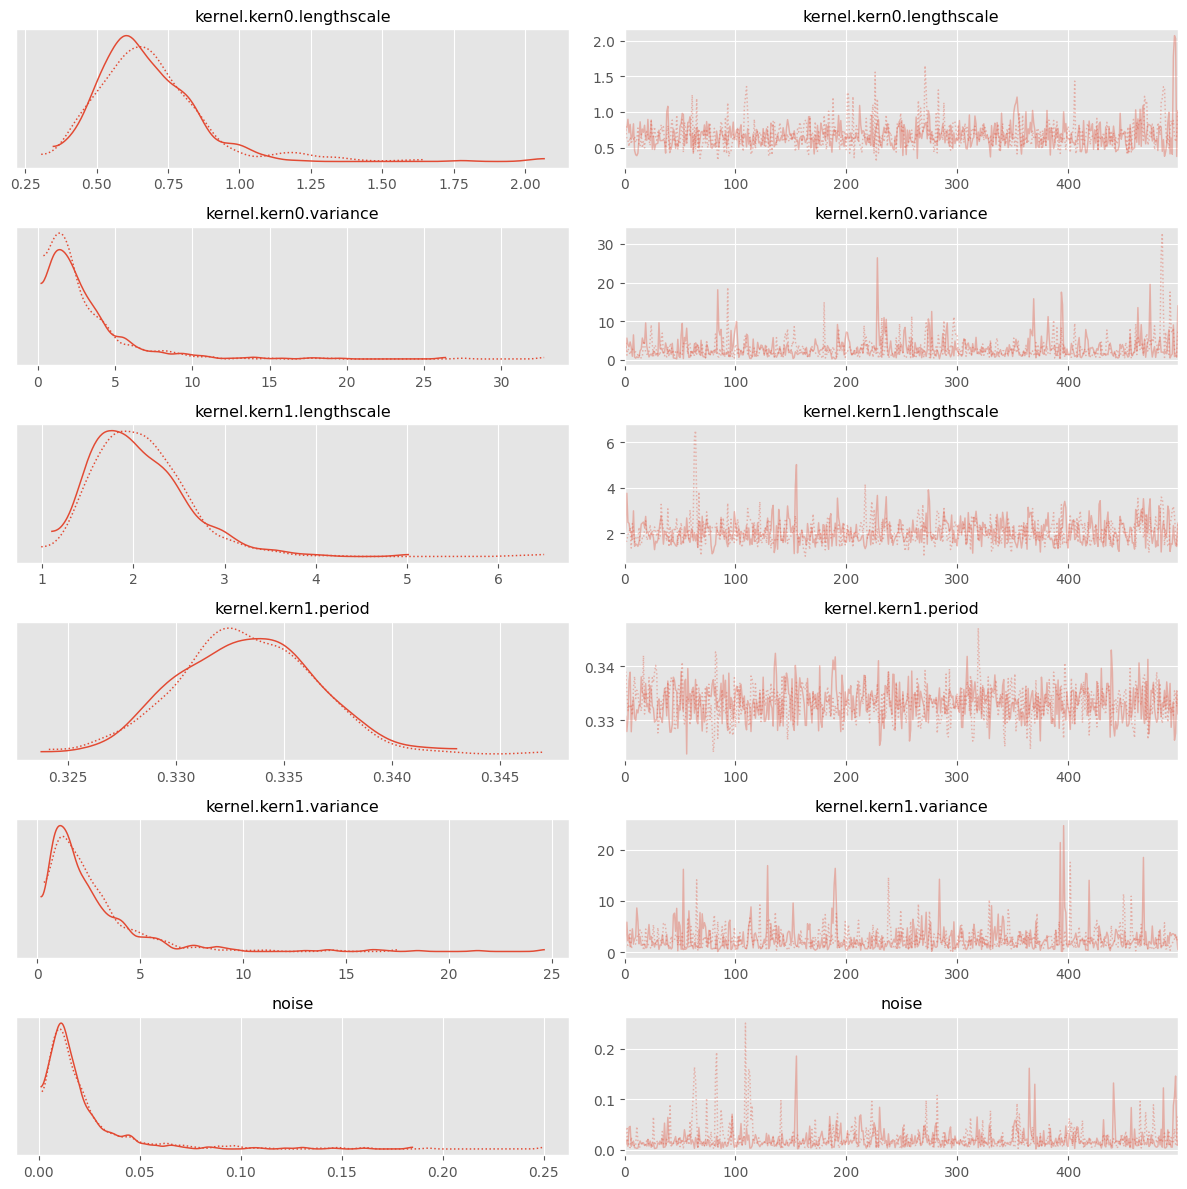

In [53]:
az.plot_trace(data)
plt.tight_layout()
# plt.savefig("arviz_trace.png", dpi=600)


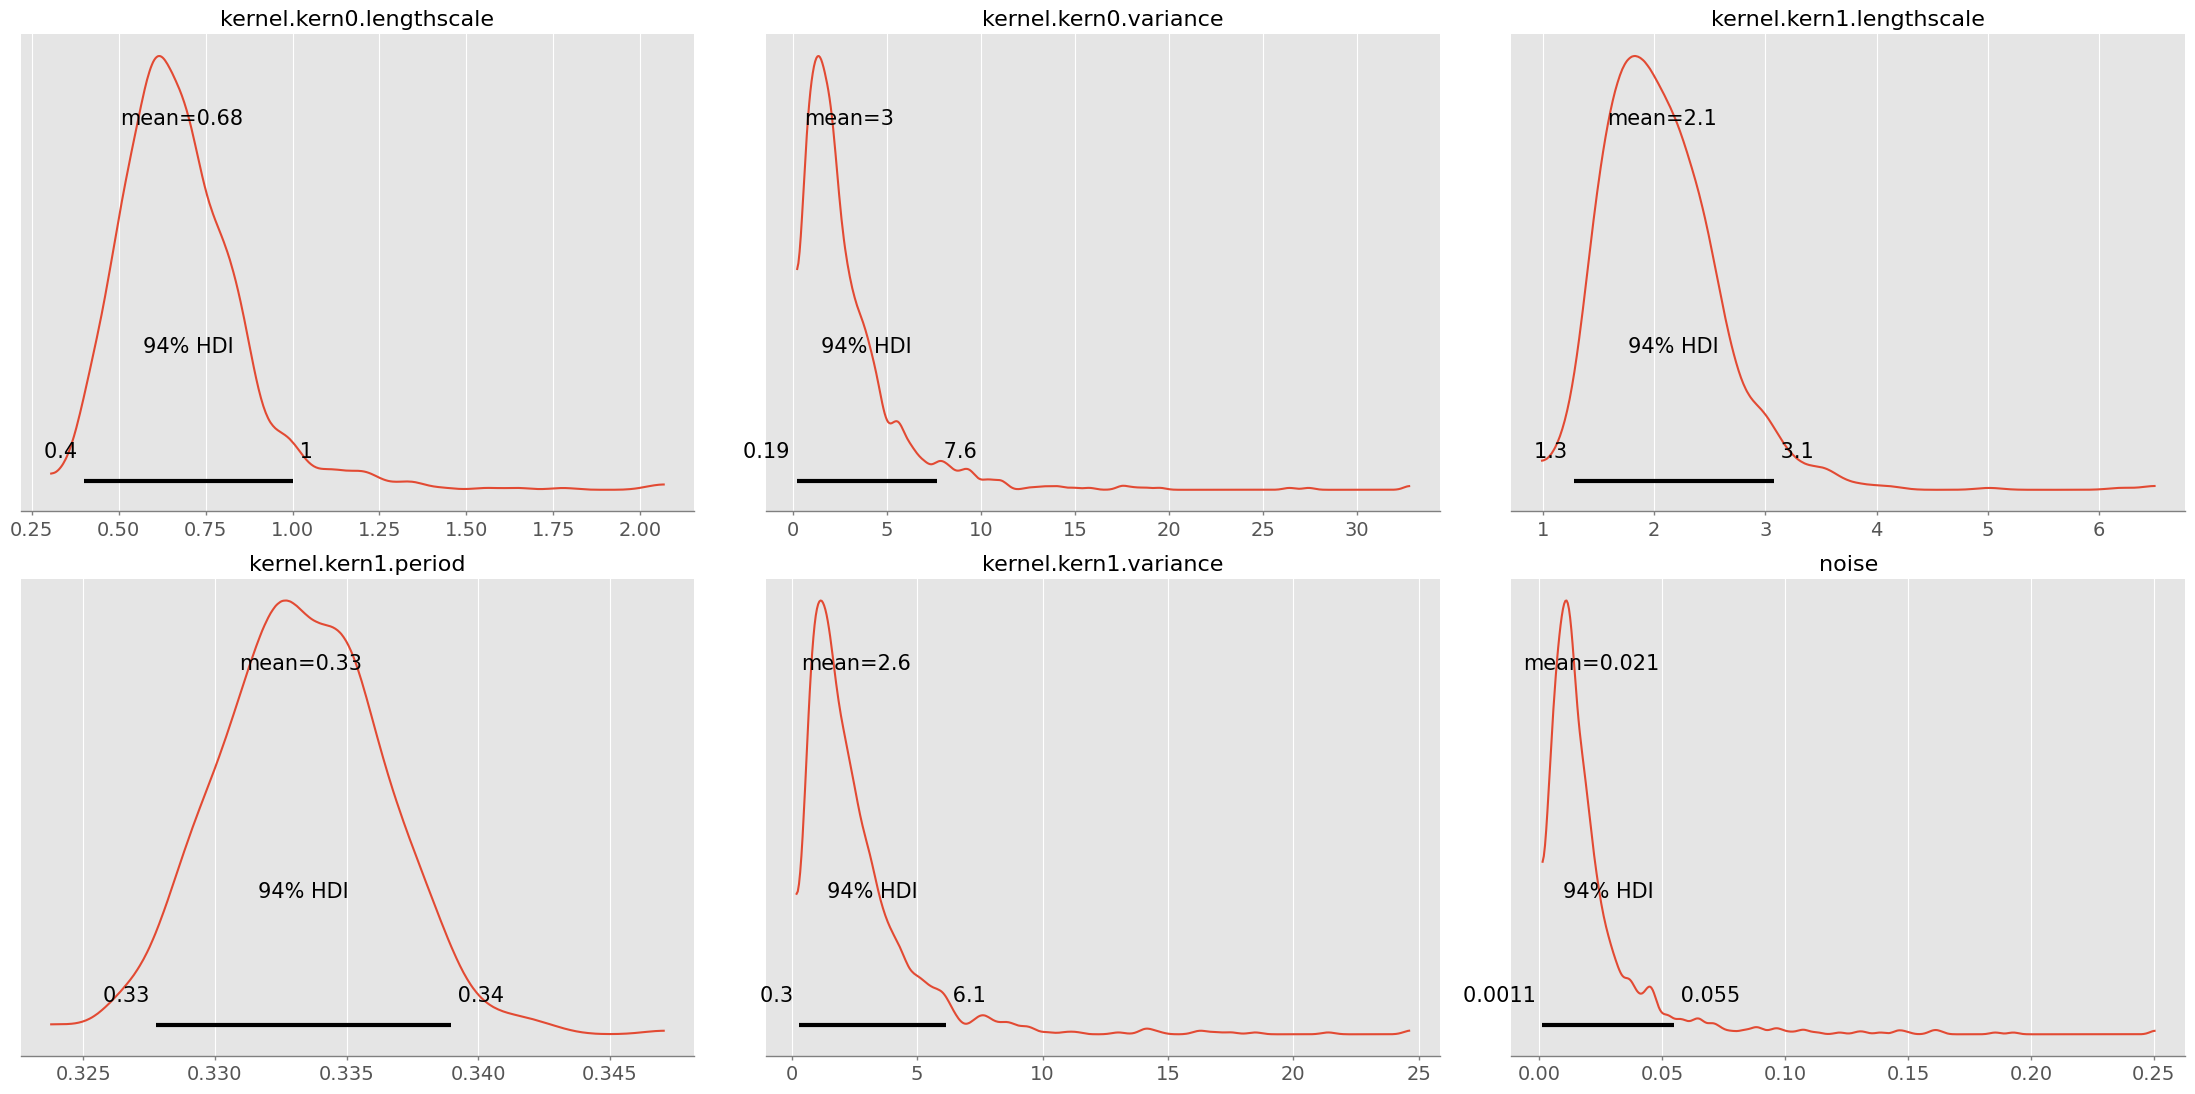

In [54]:
az.plot_posterior(data)
plt.tight_layout()
# plt.savefig("arviz_posterior.png", 6pi=400)


In [55]:
summary = az.summary(data)
summary


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel.kern0.lengthscale,0.680,0.185,0.399,1.000,0.007,0.006,837.0,437.0,1.01
kernel.kern0.variance,2.964,2.905,0.188,7.642,0.124,0.088,617.0,511.0,1.00
kernel.kern1.lengthscale,2.075,0.540,1.277,3.074,0.022,0.017,745.0,599.0,1.01
kernel.kern1.period,0.333,0.003,0.328,0.339,0.000,0.000,906.0,735.0,1.00
kernel.kern1.variance,2.579,2.387,0.299,6.141,0.089,0.067,738.0,702.0,1.00
noise,0.021,0.023,0.001,0.055,0.001,0.001,530.0,621.0,1.00


In [56]:
df = pd.DataFrame(summary)
print(df.to_latex())


\begin{tabular}{lrrrrrrrrr}
\toprule
 & mean & sd & hdi_3% & hdi_97% & mcse_mean & mcse_sd & ess_bulk & ess_tail & r_hat \\
\midrule
kernel.kern0.lengthscale & 0.680000 & 0.185000 & 0.399000 & 1.000000 & 0.007000 & 0.006000 & 837.000000 & 437.000000 & 1.010000 \\
kernel.kern0.variance & 2.964000 & 2.905000 & 0.188000 & 7.642000 & 0.124000 & 0.088000 & 617.000000 & 511.000000 & 1.000000 \\
kernel.kern1.lengthscale & 2.075000 & 0.540000 & 1.277000 & 3.074000 & 0.022000 & 0.017000 & 745.000000 & 599.000000 & 1.010000 \\
kernel.kern1.period & 0.333000 & 0.003000 & 0.328000 & 0.339000 & 0.000000 & 0.000000 & 906.000000 & 735.000000 & 1.000000 \\
kernel.kern1.variance & 2.579000 & 2.387000 & 0.299000 & 6.141000 & 0.089000 & 0.067000 & 738.000000 & 702.000000 & 1.000000 \\
noise & 0.021000 & 0.023000 & 0.001000 & 0.055000 & 0.001000 & 0.001000 & 530.000000 & 621.000000 & 1.000000 \\
\bottomrule
\end{tabular}



In [ ]:
mcmc_test_loglikelihoods = []

iterations = 20

for iteration in range(iterations):
    print(f"Iteration {iteration+1} / {iterations}")
    pyro.clear_param_store()
    x_train, y_train, x_test, y_test = generate_data()

    # Defining our kernels and GP-model
    rbf = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
    )

    periodic = gp.kernels.Periodic(
        input_dim=1,
        period=torch.tensor(0.5),
        lengthscale=torch.tensor(1.0),
        variance=torch.tensor(1.0),
    )
    kernel = gp.kernels.Sum(kern0=rbf, kern1=periodic)

    gpr = gp.models.GPRegression(
        x_train, y_train, kernel=kernel, noise=torch.tensor(0.01)
    )

    # Putting priors on our kernel parameters
    gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.kernel.kern1.period = pyro.nn.PyroSample(
        dist.LogNormal(torch.log(torch.tensor(1 / 3)), 0.1**2)
    )
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))

    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True, adapt_step_size=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=500)
    mcmc.run()

    posterior_samples = mcmc.get_samples(num_samples=500)

    mcmc_test_loglikelihoods.append(log_likelihood(x_test, y_test, posterior_samples))


Iteration 1 / 20


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 2 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 3 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 4 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Iteration 5 / 20


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 6 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 7 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Iteration 8 / 20


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 9 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

Iteration 10 / 20


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

In [58]:
print(mcmc_test_loglikelihoods)


[tensor(-12.5294, grad_fn=<MulBackward0>)]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

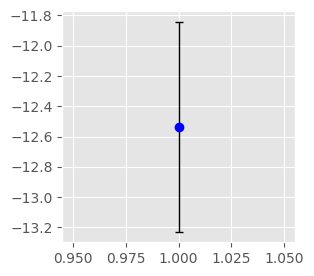

In [59]:
map_log_likelihood = [
    -12.845663070678711,
    -11.92534065246582,
    -12.938199996948242,
    -13.013025283813477,
    -12.58405876159668,
    -14.971349716186523,
    -12.813676834106445,
    -12.296675682067871,
    -12.014432907104492,
    -12.408483505249023,
    -12.0713529586792,
    -12.794227600097656,
    -12.345871925354004,
    -12.234722137451172,
    -11.607013702392578,
    -12.453836441040039,
    -12.268890380859375,
    -12.202347755432129,
    -12.940900802612305,
    -11.98383903503418,
]


# mcmc_log_likelihood = [tensor.to_numpy() for tensor in test_loglikelihoods]
fig, ax = plt.subplots(figsize=(3, 3))
ax.errorbar(
    1,
    np.mean(map_log_likelihood),
    yerr=np.std(map_log_likelihood, ddof=1),
    ecolor="k",
    capsize=3,
    elinewidth=1,
    color="b",
    fmt="o",
)
ax.errorbar(
    2,
    np.mean(mcmc_test_loglikelihoods),
    yerr=np.std(mcmc_test_loglikelihoods, ddof=1),
    ecolor="k",
    capsize=3,
    elinewidth=1,
    color="r",
    fmt="o",
)
ax.set_xticks([1, 2], ["MAP", "NUTS"])
ax.set_xlim(0, 3)
ax.set(ylabel="Posterior log likelihood")
plt.tight_layout()
plt.savefig("B1_loglikelihood_comp.png", dpi=400)
plt.show()
print("MAP:", np.mean(map_log_likelihood), np.std(map_log_likelihood, ddof=1))
print(
    "NUTS:", np.mean(mcmc_test_loglikelihoods), np.std(mcmc_test_loglikelihoods, ddof=1)
)
